In [1]:
import pyhull
import string
import math
import numpy as np
from pylab import*
from pytope import Polytope
from scipy.spatial import ConvexHull
from __future__ import division
from mpl_toolkits.mplot3d import Axes3D
import picos
import scipy.optimize
import matplotlib.pyplot as plt
import control
import slycot

In [2]:
import nbimporter
import SE2_with_Disturbance as SE_Dist
import FlowPipe2D as fp2d

In [3]:
def solve_lmi(alpha, A1, A2, U1, U2, verbosity=0):
    # also maximize dV
    
    prob = picos.Problem()
    P = picos.SymmetricVariable('P', (3, 3))
    P1 = P[:2, :]
    P2 = P[2, :]
    mu1 = picos.RealVariable('mu_1')
    mu2 = picos.RealVariable('mu_2')
    gam = mu1 + mu2
    block_eq1 = picos.block([
         [A1.T*P + P*A1 + alpha*P, P1.T*U1, P1.T*U2 + P2.T],
         [U1.T*P1, -alpha*mu1*np.eye(2), 0],
         [U2.T*P1 + P2, 0, -alpha*mu2]])
    block_eq2 = picos.block([
         [A2.T*P + P*A2 + alpha*P, P1.T*U1, P1.T*U2 + P2.T],
         [U1.T*P1, -alpha*mu1*np.eye(2), 0],
         [U2.T*P1 + P2, 0, -alpha*mu2]])
    prob.add_constraint(block_eq1 << 0) # dV < 0
    prob.add_constraint(block_eq2 << 0)
    prob.add_constraint(P >> 1)
    prob.add_constraint(mu1 >> 0)
    prob.add_constraint(mu2 >> 0)
    prob.set_objective('min', mu1 + mu2)
    try:
        prob.solve(options={'verbosity': verbosity})
        cost = gam.value
    except Exception as e:
        print(e)
        cost = -1
    return {
        'cost': cost,
        'prob': prob,
        'mu1': mu1.value,
        'mu2': mu2.value,
        'P': np.round(np.array(P.value), 3),
        'alpha':alpha,
        'gam': gam
    }


def solve_control_gain():
    ### A needs to be polytopic
    A = np.array([
        [0, 0, 0],
        [0, 0, 1],
        [0, 0, 0]])
    B = np.array([[1, 0], [0, 0], [0, 1]])
    Q = 10*np.eye(3)  # penalize state
    R = 1*np.eye(2)  # penalize input
    K, _, _ = control.lqr(A, B, Q, R)
    K = -K  # rescale K, set negative feedback sign
    A0 = A + B@K
    return K, B, A0


def find_se2_invariant_set(value, verbosity=0):
    dA = np.array([
        [0, -1, 0],
        [1, 0, 0],
        [0, 0, 0]])    
    A0 = solve_control_gain()[2]
    A1 = A0 + (0)*dA
    A2 = A0 + pi/4*dA

    # these are the two parts of U(x), split ast U(x) = [U1, U2], where the first impacts the u, v and the last impacts the w disturbance
    # these are the zero order terms of the taylor expansion below
    # TODO: could add polytopic system with bounded input disturbance, U(x) is actually a function of the state not a constant, so this 
    # is an under approximation as is
    U1 = np.eye(2)*value # multiply singular val of U
    U2 = np.array([
        [0],
        [0]])
    
    # we use fmin to solve a line search problem in alpha for minimum gamma
    if verbosity > 0:
        print('line search')
    
    # we perform a line search over alpha to find the largest convergence rate possible
    alpha_1 = np.max(np.array([np.linalg.eig(A1)[0],np.linalg.eig(A2)[0]]))
    alpha_2 = np.max(np.linalg.eig(A2)[0])
    alpha_opt = scipy.optimize.fminbound(lambda alpha: solve_lmi(alpha, A1, A2, U1, U2, verbosity=verbosity)['cost'], x1=0.001, x2=-alpha_1, disp=True if verbosity > 0 else False)
    #print(alpha_opt1)
    #alpha_opt2 = scipy.optimize.fminbound(lambda alpha: solve_lmi(alpha, A1, A2, U1, U2, verbosity=verbosity)['cost'], x1=0.001, x2=-alpha_2, disp=True if verbosity > 0 else False)
    #print(alpha_opt2)
    #alpha_opt = np.min(np.array([alpha_opt1, alpha_opt2]))
    
    sol = solve_lmi(alpha_opt, A1, A2, U1, U2)
    prob = sol['prob']
    if prob.status == 'optimal':
        P = prob.variables['P'].value
        mu1 =  prob.variables['mu_1'].value
        mu2 =  prob.variables['mu_2'].value
        if verbosity > 0:
            print(sol)
    else:
        raise RuntimeError('Optimization failed')
        
    return sol

In [4]:
def svd(theta):
    return (sqrt(-2/(cos(theta)-1))*abs(theta))/2

In [5]:
def se2_lie_algebra_invariant_set_points(sol, t, w1_norm, w2_norm, e0): # w1_norm (x-y direc): wind speed
    P = sol['P']
    # V = xTPx scalar
    beta = (e0.T@P@e0) # V0
    #print('V0', beta)
    val = beta*exp(-sol['alpha']*t) + sol['mu1']*w1_norm**2 + sol['mu2']*w2_norm**2 # V(t)
    #print('val', val)
    
    # 1 = xT(P/V(t))x, equation for the ellipse
    evals, evects = np.linalg.eig(P/val)
    radii = 1/np.sqrt(evals)
    R = evects@np.diag(radii)
    R = np.real(R)
    
    # draw sphere
    points = []
    n = 25
    for u in np.linspace(0, 2*np.pi, n):
        for v in np.linspace(0, 2*np.pi, 2*n):
            points.append([np.cos(u)*np.sin(v), np.sin(u)*np.sin(v), np.cos(v)])
    for v in np.linspace(0, 2*np.pi, 2*n):
        for u in np.linspace(0, 2*np.pi, n):
            points.append([np.cos(u)*np.sin(v), np.sin(u)*np.sin(v), np.cos(v)])
    points = np.array(points).T
    #u, v = np.mgrid[0:2*np.pi:20j, 0:2*np.pi:40j]
    #x = np.cos(u) * np.sin(v)
    #y = np.sin(u) * np.sin(v)
    #z = np.cos(v)
    #points = np.vstack([x.reshape(-1), y.reshape(-1), z.reshape(-1)])
    return R@points

In [6]:
def hj_invariant_set_points(r): # w1_norm (x-y direc): wind speed
    
    R = r*eye(3,3)
    print(R)
    # draw sphere
    points = []
    n = 25
    for u in np.linspace(0, 2*np.pi, n):
        for v in np.linspace(0, 2*np.pi, 2*n):
            points.append([np.cos(u)*np.sin(v), np.sin(u)*np.sin(v), np.cos(v)])
    for v in np.linspace(0, 2*np.pi, 2*n):
        for u in np.linspace(0, 2*np.pi, n):
            points.append([np.cos(u)*np.sin(v), np.sin(u)*np.sin(v), np.cos(v)])
    points = np.array(points).T
    #u, v = np.mgrid[0:2*np.pi:20j, 0:2*np.pi:40j]
    #x = np.cos(u) * np.sin(v)
    #y = np.sin(u) * np.sin(v)
    #z = np.cos(v)
    #points = np.vstack([x.reshape(-1), y.reshape(-1), z.reshape(-1)])
    return R@points

In [7]:
def SE2_exp_wedge(a): 
    assert a.shape == (3,)
    alpha = a[2]
    u1 = a[0]
    u2 = a[1]
    if abs(alpha) < 0.1:
        t1 = 1 - alpha**2/6 + alpha**4/120 
        t2 = alpha/2 - alpha**3/24 - alpha**5/720 
    else:
        t1 = sin(alpha)/alpha
        t2 = (1-cos(alpha))/alpha
    x = np.array([[t1, -t2],
                  [t2, t1]])@[u1,u2]
    return array([x[0], x[1], alpha])
def se2_log(a):
    assert a.shape == (3,)
    theta = a[2]
    x = a[0]
    y = a[1]
    with np.errstate(divide='ignore',invalid='ignore'):
        a = np.where(np.abs(theta) < 1e-3, 1 - theta**2/6 + theta**4/12, np.sin(theta)/theta)
        b = np.where(np.abs(theta) < 1e-3, theta/2 - theta**3/24 + theta**5/720, (1 - np.cos(theta))/theta)
    V_inv = np.array([
        [a, b],
        [-b, a]
    ])/(a**2 + b**2)
    p = V_inv@np.array([x, y])
    return array([p[0], p[1], theta])

In [8]:
w1 = .1
w2 = .1
e = array([0, 0, 0]) # Lie Group
e0 = se2_log(e) # Lie Algebra
t = 0
sv = []
a_theta = []
Mt = []
mt = []

for i in linspace(1e-5, pi, 21):
    value = svd(i)
    sol = find_se2_invariant_set(value)
    
    points = se2_lie_algebra_invariant_set_points(sol, t, w1, w2, e0) #Lie Algebra
    max_theta = points[2,:].max()
    min_theta = points[2,:].min()
    
    a_theta.append(i)
    sv.append(value)
    Mt.append(max_theta)
    mt.append(min_theta)

In [9]:
from tabulate import tabulate
info = {'theta': a_theta, 'Singular value': sv, 'Max inv theta': Mt, 'min inv theta': mt}
print(tabulate(info, headers='keys'))

   theta    Singular value    Max inv theta    min inv theta
--------  ----------------  ---------------  ---------------
1e-05              1               0.192312        -0.192458
0.157089           1.00103         0.192688        -0.192829
0.314168           1.00412         0.192832        -0.192977
0.471247           1.00931         0.193636        -0.193776
0.628327           1.01664         0.194517        -0.194655
0.785406           1.02617         0.196149        -0.196276
0.942485           1.03799         0.197473        -0.197598
1.09956            1.05221         0.199643        -0.199757
1.25664            1.06896         0.201875        -0.201979
1.41372            1.0884          0.204683        -0.204774
1.5708             1.11072         0.208011        -0.208085
1.72788            1.13615         0.211325        -0.211388
1.88496            1.16497         0.215362        -0.215405
2.04204            1.19748         0.219706        -0.219733
2.19912            1.234

[0. 0. 0.]


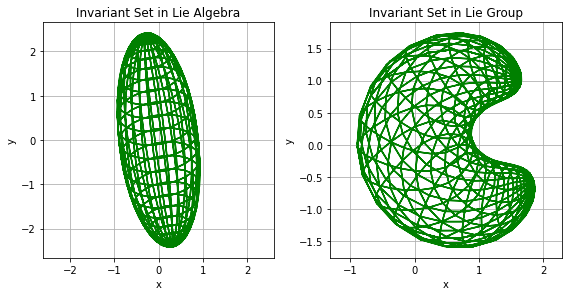

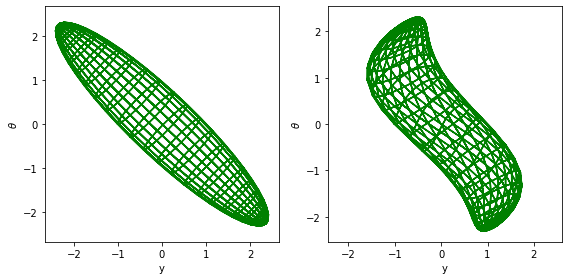

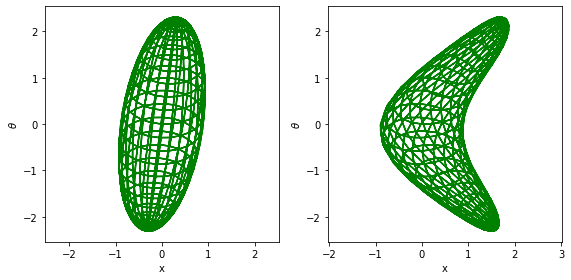

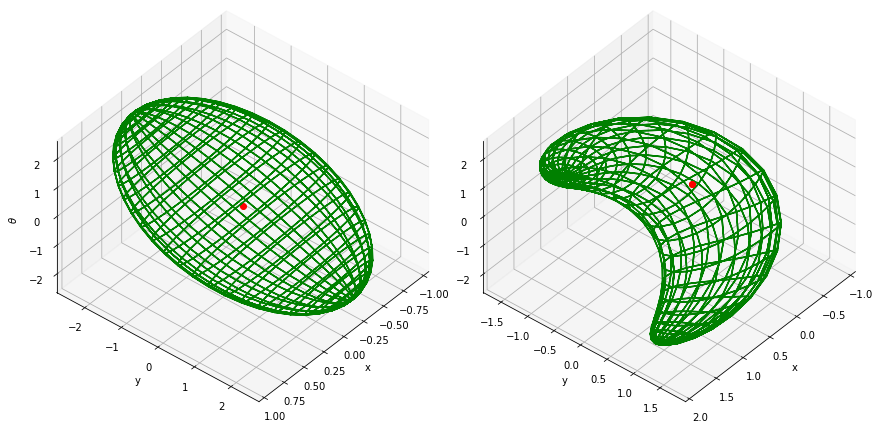

In [10]:
sol = find_se2_invariant_set(svd(15*pi/20))
w1 = 1
w2 = 1
e = array([0, 0, 0]) # Lie Group
e0 = se2_log(e) # Lie Algebra
print(e0)

t = 0
points = se2_lie_algebra_invariant_set_points(sol, t, w1, w2, e0) #Lie Algebra

exp_points = np.zeros((3,points.shape[1]))
for i in range(points.shape[1]):
    exp_points[:,i] = SE2_exp_wedge(points[:,i])


plt.figure(figsize=(8,4))
ax = plt.subplot(121)
ax.plot(points[0, :], points[1, :], 'g');
ax.set_xlabel('x')
ax.set_ylabel('y')
#ax.plot(e0[0],e0[1],'ro')
plt.axis('equal')
plt.grid(True)
ax2 = plt.subplot(122)
ax2.plot(exp_points[0, :-1], exp_points[1, :-1], 'g');
#ax2.plot(e[0],e[1],'ro')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
ax.set_title('Invariant Set in Lie Algebra')
ax2.set_title('Invariant Set in Lie Group')

plt.figure(figsize=(8,4))
ax = plt.subplot(121)
ax.plot(points[1, :], points[2, :], 'g');
ax.set_xlabel('y')
ax.set_ylabel('$\\theta$')
plt.axis('equal')
ax2 = plt.subplot(122)
ax2.plot(exp_points[1, :], exp_points[2, :], 'g');
ax2.set_xlabel('y')
ax2.set_ylabel('$\\theta$')
plt.axis('equal')
plt.tight_layout()

plt.figure(figsize=(8,4))
ax = plt.subplot(121)
ax.plot(points[0, :], points[2, :], 'g');
ax.set_xlabel('x')
ax.set_ylabel('$\\theta$')
plt.axis('equal')
ax2 = plt.subplot(122)
ax2.plot(exp_points[0, :], exp_points[2, :], 'g');
ax2.set_xlabel('x')
ax2.set_ylabel('$\\theta$')
plt.axis('equal')
plt.tight_layout()

plt.figure(figsize=(12,6))
ax = plt.subplot(121, projection='3d', proj_type='ortho', elev=40, azim=40)
ax.plot3D(e0[0], e0[1], e0[2], 'ro');
ax.plot3D(points[0, :], points[1, :], points[2, :],'g');
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('$\\theta$')
plt.axis('auto')
ax2 = plt.subplot(122, projection='3d', proj_type='ortho', elev=40, azim=40)
ax2.plot3D(e[0], e[1], e[2], 'ro');
ax2.plot3D(exp_points[0, :], exp_points[1, :], exp_points[2, :], 'g');
ax2.plot3D(e[0], e[1], e[2], 'ro');
ax2.set_xlabel('x')
ax2.set_ylabel('y')
plt.axis('auto')
plt.tight_layout()

[[1.8 0.  0. ]
 [0.  1.8 0. ]
 [0.  0.  1.8]]


Text(0.5, 1.0, 'Invariant Set from LMI')

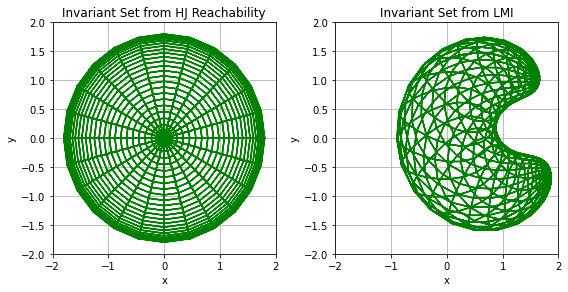

In [11]:
hj_points = hj_invariant_set_points(1.8) 


plt.figure(figsize=(8,4))
ax = plt.subplot(121)
ax.plot(hj_points[0, :], hj_points[1, :], 'g');
ax.set_xlabel('x')
ax.set_ylabel('y')
#ax.plot(e0[0],e0[1],'ro')
ax.set_xlim([-2,2])
ax.set_ylim([-2,2])
plt.grid(True)
ax2 = plt.subplot(122)
ax2.plot(exp_points[0, :-1], exp_points[1, :-1], 'g');
#ax2.plot(e[0],e[1],'ro')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
plt.grid(True)
ax2.set_xlim([-2,2])
ax2.set_ylim([-2,2])
plt.tight_layout()
ax.set_title('Invariant Set from HJ Reachability')
ax2.set_title('Invariant Set from LMI')

In [13]:
def rotate_point(point, angle):
    new_point = array([point[0] * cos(angle) - point[1] * sin(angle),
                 point[0] * sin(angle) + point[1] * cos(angle)])
    return new_point

In [14]:
def flowpipes(res, tf, n, e0, w1, w2, sol):
    
    t_vect = np.arange(0, tf, 0.05)
    
    y_vect = res['y']
    x, y, theta, x_r, y_r, theta_r, log_e_x, log_e_y, log_e_theta = [y_vect[i, :] for i in range(len(y_vect))]
    
    nom = array([x_r,y_r]).T
    flowpipes = []
    intervalhull = []
    if len(t_vect)%n == 0:
        steps = int(len(t_vect)/n)
    else:
        steps = int(len(t_vect)/n + 1)
    a = n      
    
    for i in range(n):
        if (steps*(i+1)) <= len(t_vect):
            nom_i = nom[steps*i:steps*(i+1),:] # steps*2
        else:
            nom_i = nom[steps*i:len(t_vect),:]
            
        # Get interval hull
        hull_points = fp2d.qhull2D(nom_i)
        # Reverse order of points, to match output from other qhull implementations
        hull_points = hull_points[::-1]
        (rot_angle, area, width, height, center_point, corner_points) = fp2d.minBoundingRect(hull_points)
        # add first corner_points to last
        corner_points = np.append(corner_points, corner_points[0].reshape(1,2), axis = 0)
        
        dx = corner_points[0][0]-corner_points[1][0]
        if width > height:
            if dx > .1:
                angle = np.arccos((corner_points[0][0]-corner_points[1][0])/width)
            else:
                angle = np.arccos((corner_points[2][0]-corner_points[1][0])/width)
        else:
            if dx > .1:
                angle = np.arccos((corner_points[0][0]-corner_points[1][0])/height)
            else:
                angle = np.arccos((corner_points[2][0]-corner_points[1][0])/height) 
        # fix mess up part
        if angle > 3:
            if i < int(n/3):
                angle = angle - pi
        if angle < 1:
            if i > int(n/3):
                a = i
        if i >= a:
            angle = angle + pi
        
        t = 0.05*i*steps
        # invariant set in se2
        points = se2_lie_algebra_invariant_set_points(sol, t, w1, w2, e0)
        
        # exp map
        exp_points = np.zeros((3,points.shape[1]))
        for i in range(points.shape[1]):
            exp_points[:,i] = SE2_exp_wedge(points[:,i])
            
        # invariant set in SE2   
        inv_points = rotate_point(exp_points, angle)
        
        P2 = Polytope(inv_points.T)
        # minkowski sum
        P1 = Polytope(corner_points) # interval hull
        P = P1+P2 # sum
        p1_vertices = P1.V
        p_vertices = P.V
        p_vertices = np.append(p_vertices, p_vertices[0].reshape(1,2), axis = 0)
        flowpipes.append(p_vertices)
        intervalhull.append(p1_vertices)
    return flowpipes, intervalhull, nom

In [15]:
def circ_inv(r):
    theta_circ = np.linspace(0, 2*np.pi, 100)
    circ = array([r*np.cos(theta_circ), r*np.sin(theta_circ)]).T
    return circ

In [16]:
def w(sol, x):
    U1 = np.eye(2)*pi/2 # multiply singular val of U
    U2 = np.array([
        [0],
        [0]])
    P = sol['P']
    P1 = P[:2, :]
    P2 = P[2, :]
    mu1 = sol['mu1'] 
    mu2 = sol['mu2']
    alpha = sol['alpha']
    
    w1 = ((U1@P1@x + x@P1.T@U1)/(2*alpha*mu1)).real
    w2 = ((U2.T@P1+P2)@x/(alpha*mu2)).real
    
    return w1, w2

In [17]:
w1, w2 =w(sol, [1,1,1])
w1

array([2.26463596, 4.08747001])

# Flow Pipes Simulation

In [18]:
t = 40
n = 40 # number of interval hulls
# disturbances
w1 = 1
w2 = 1  
sol1 = find_se2_invariant_set(svd(3*pi/4)) # u, v, w1, w2

ref = SE_Dist.simulate(t, 0, w1, w2, 0, 0, 0, dist='sine', sol= sol1, use_approx=False)
e0 = se2_log(array([0, 0, -pi/10]))

flow_pipes_LMI, intervalhull_LMI, nom = flowpipes(ref, t, n, e0, w1, w2, sol)

#TEB_small = circ_inv(1.476) # HJB w/ control bound [-pi,pi]
#L_small = circ_inv(1.4487) # lyapunov w/ small theta_max
#L_large = circ_inv(2.1136) # lyapunov w/ large theta_max
#flow_pipes_Ls, intervalhull_Ls, nom, ang = flowpipes(res,L_small,t, n)
#flow_pipes_Ll, intervalhull_Ll, nom = flowpipes(xr,r_large,t, n)
#flow_pipes_Hs, intervalhull_Hs, nom, ang = flowpipes(res,TEB_small,t, n)
#flow_pipes_Hl, intervalhull_Hl, nom = flowpipes(xr,TEB,t, n)

Text(0, 0.5, 'y')

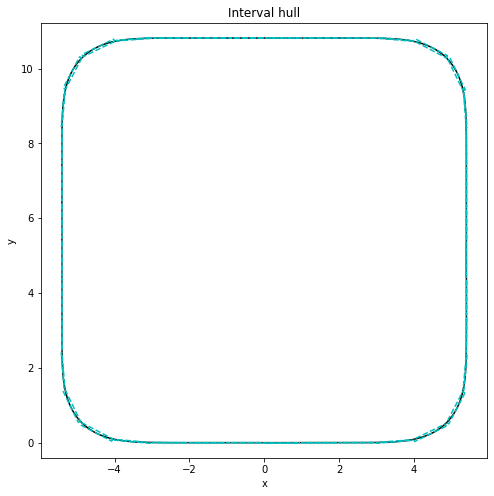

In [19]:
# interval hull
plt.figure(figsize=(8,8))
ax = subplot(111)
h_nom = ax.plot(nom[:,0], nom[:,1], color='k', linestyle='-')
for facet in range(n):
    hs_ch_LMI = ax.plot(intervalhull_LMI[facet][:,0], intervalhull_LMI[facet][:,1], color='c', linestyle='--')
    #hs_ch_Ls = ax.plot(intervalhull_Ls[facet][:,0], intervalhull_Ls[facet][:,1], color='m', linestyle='--')
    #hs_ch_Hs = ax.plot(flow_pipes_Hs[facet][:,0], flow_pipes_Hs[facet][:,1], color='m', linestyle='--', alpha = 0.5)

plt.axis('equal')
title('Interval hull')
xlabel('x')
ylabel('y')
#legend([h_nom[0], hs_ch_Ls[0]], ['nominal', 'interval hull'], loc=1);

Text(0, 0.5, 'y')

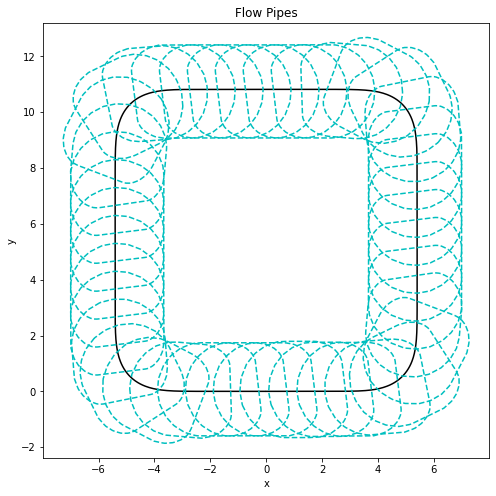

In [21]:
# flow pipes
plt.figure(figsize=(8,8))
ax = subplot(111)
h_nom = ax.plot(nom[:,0], nom[:,1], color='k', linestyle='-')
for facet in range(n):
    hs_ch_LMI = ax.plot(flow_pipes_LMI[facet][:,0], flow_pipes_LMI[facet][:,1], color='c', linestyle='--')
    #hs_ch_LMI_L = ax.plot(flow_pipes_LMI_L[facet][:,0], flow_pipes_LMI_L[facet][:,1], color='y', linestyle='--')
    #hs_ch_Hs = ax.plot(flow_pipes_Hs[facet][:,0], flow_pipes_Hs[facet][:,1], color='m', linestyle='--', alpha = 0.5)

plt.axis('equal')
title('Flow Pipes')
xlabel('x')
ylabel('y')
#legend([h_nom[0], hs_ch_LMI[0], hs_ch_LMI_L[0]], ['nominal', 'flow pipe (small)', 'flow pipe (Large)'], loc=1);

# Trajectories simulation

[[ 0.1       ]
 [-0.1       ]
 [-0.31415927]]
[ 0.11488414 -0.08346821 -0.31415927]


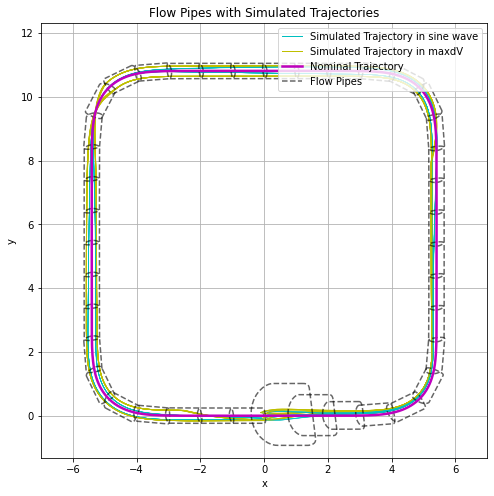

In [22]:
# small distrubance
freq = [0.02, .04]#, .06, .08, .01, .03, .05, .07, .09]
res = []
t = 40
n = 40 # number of interval hulls
# disturbances
w1 = .1
w2 = .1
sol_s = find_se2_invariant_set(svd(3*pi/20))
ref = SE_Dist.simulate(t, 0, w1, w2, 0, 0, 0, dist='sine', sol= sol_s, use_approx=False)
e = []
V=[]

for theta0 in np.linspace(-pi/10, pi/10, 2):
    for x0 in np.linspace(-.1, .1, 2):
        for y0 in np.linspace(-.1, .1, 2):
                init_e = array([[x0, y0, theta0]]).T
                V0 = init_e.T@sol['P']@init_e
                V.append(V0)
                e.append(init_e)
                for i in freq:
                    r = SE_Dist.simulate(40, i, w1, w2, x0, y0, theta0, dist='sine', sol= sol_s, use_approx=False)
                    r2 = SE_Dist.simulate(40, i, w1, w2, x0, y0, theta0, dist='square', sol= sol_s, use_approx=False)
                    res.append(r)
                    if theta0 == np.pi/10 and x0 == .1 and y0 == .1 and i == freq[-1]:
                        SE_Dist.plot_simulated(r, name='sine wave', legend=True, save=False, linewidth = 1, color = 'c')
                        SE_Dist.plot_simulated(r2, name='maxdV', legend=True, save=False, linewidth = 1, color = 'y')
                    else:
                        SE_Dist.plot_simulated(r, name='', legend=False, save=False, linewidth = .5, color = 'c')
                        SE_Dist.plot_simulated(r2, name='', legend=False, save=False, linewidth = 1, color = 'y')
                        
i = np.array(V).argmax()
print(e[i])
e0 = se2_log(array(e[i]).reshape(3,))
print(e0)

flow_pipes_LMI, intervalhull_LMI, nom = flowpipes(ref, t, n, e0, w1, w2, sol)
for facet in range(n):
    hs_ch_LMI = plt.plot(flow_pipes_LMI[facet][:,0], flow_pipes_LMI[facet][:,1], color='k', linestyle='--', alpha = 0.6)
    
h_nom = plt.plot(nom[:,0], nom[:,1], color='m', linestyle='-', linewidth = 2.5)

plt.axis('equal')
plt.xlim([-7, 7])
plt.ylim([-3, 14])
title('Flow Pipes with Simulated Trajectories')
xlabel('x')
ylabel('y')

lgd = plt.legend(loc=1)
ax = lgd.axes
handles, labels = ax.get_legend_handles_labels()
handles.append(h_nom[0])
labels.append('Nominal Trajectory')
handles.append(hs_ch_LMI[0])
labels.append('Flow Pipes')
lgd._legend_box = None
lgd._init_legend_box(handles, labels)
lgd._set_loc(lgd._loc)
lgd.set_title(lgd.get_title().get_text())

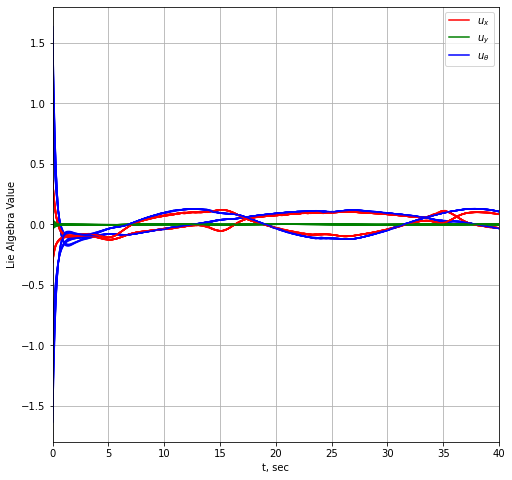

In [21]:
# small distrubance
freq = [0.02, .04]#, .06, .08, .01, .03, .05, .07, .09]
res = []
t = 40
n = 40 # number of interval hulls
# disturbances
w1 = .1
w2 = .1
sol_s = find_se2_invariant_set(svd(3*pi/20))


for theta0 in np.linspace(-pi/10, pi/10, 2):
    for x0 in np.linspace(-.1, .1, 2):
        for y0 in np.linspace(-.1, .1, 2):
                for i in freq:
                    r = SE_Dist.simulate(40, i, w1, w2, x0, y0, theta0, dist='sine', sol= sol_s, use_approx=False)
                    res.append(r)
                    if theta0 == np.pi/10 and x0 == .1 and y0 == .1 and i == freq[-1]:
                        SE_Dist.plot_control(r, name='sine wave', legend=True, save=False, linewidth = 1, color = 'c')
                    else:
                        SE_Dist.plot_control(r, name='', legend=False, save=False, linewidth = .5, color = 'c')
                        




plt.xlim([0, 40])
#plt.ylim([-2, 2])

plt.legend(loc=1)

[ 0.          0.         -0.31415927]


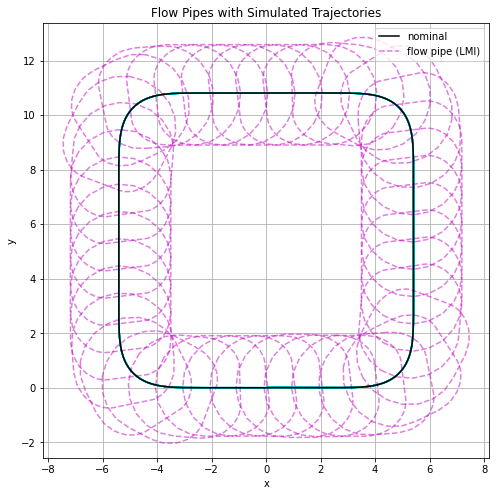

In [17]:
# large disturbance
freq = [0.02, .04, .06, .08, .01, .03, .05, .07, .09]
res = []
t = 40
n = 40 # number of interval hulls
# disturbances
w1 = 1
w2 = 1  
ref = SE_Dist.simulate(t, 0, w1, w2, 0, 0, 0, dist='sine', sol= sol1, use_approx=False)


init_e = array([[0, 0, -pi/10]]).T 
V0 = init_e.T@sol['P']@init_e
for i in freq:
    r = SE_Dist.simulate(40, i, w1, w2, init_e[0], init_e[1], init_e[2], dist='maxdV', sol= sol1, use_approx=False)
    SE_Dist.plot_simulated(r, color='c', name='sine wave', legend=True, save=False)
    res.append(r)
                
e0 = se2_log(init_e.reshape(3,))
print(e0)
flow_pipes_LMI, intervalhull_LMI, nom = flowpipes(ref, t, n, e0, w1, w2, sol)
for facet in range(n):
    hs_ch_LMI = plt.plot(flow_pipes_LMI[facet][:,0], flow_pipes_LMI[facet][:,1], color='m', linestyle='--', alpha = 0.5)
    
h_nom = plt.plot(nom[:,0], nom[:,1], color='k', linestyle='-')

plt.axis('equal')
title('Flow Pipes with Simulated Trajectories')
xlabel('x')
ylabel('y')
legend([h_nom[0], hs_ch_LMI[0]], ['nominal', 'flow pipe (LMI)'], loc=1);

# Application Example

In [19]:
V2 = np.array([[1, 0], [0, -1], [-1, 0], [0, 1]])
P2 = Polytope(V2)
p4 = (4, 6)
P3 = P2*1.5 + (0,8.5)
P4 = P2 + p4
rot_mat5 = np.array([[np.cos(np.pi/4), -np.sin(np.pi/4)],
                     [np.sin(np.pi/4), np.cos(np.pi/4)]])
P5 = 0.5*rot_mat5*P3 -(1, 0)

[[ 0.1       ]
 [-0.1       ]
 [-0.31415927]]
[ 0.11488414 -0.08346821 -0.31415927]


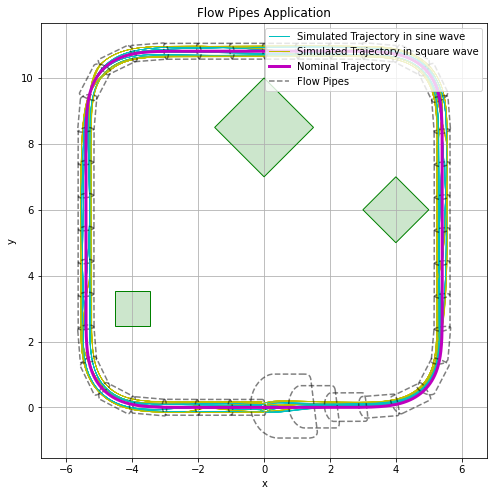

In [22]:
freq = [0.02, .04, .06, .08, .01]
res = []
e = []
V = []
t = 40
n = 40 # number of interval hulls
# disturbances
w1 = .1
w2 = .1  
ref = SE_Dist.simulate(t, 0, w1, w2, 0, 0, 0, dist='sine', sol= sol_s, use_approx=False)


for theta0 in np.linspace(-pi/10, pi/10, 2):
    for x0 in np.linspace(-.1, .1, 2):
        for y0 in np.linspace(-.1, .1, 2):
                init_e = array([[x0, y0, theta0]]).T
                V0 = init_e.T@sol['P']@init_e
                V.append(V0)
                e.append(init_e)
                for i in freq:
                    r = SE_Dist.simulate(40, i, w1, w2, x0, y0, theta0, dist='sine', sol= sol_s, use_approx=False)
                    r2 = SE_Dist.simulate(40, i, w1, w2, x0, y0, theta0, dist='square', sol= sol_s, use_approx=False)
                    res.append(r)
                    if theta0 == np.pi/10 and x0 == .1 and y0 == .1 and i == freq[-1]:
                        SE_Dist.plot_simulated(r, name='sine wave', legend=True, save=False, linewidth = 1, color = 'c')
                        SE_Dist.plot_simulated(r2, name='square wave', legend=True, save=False, linewidth = 1, color = 'y')
                    else:
                        SE_Dist.plot_simulated(r, name='', legend=False, save=False, linewidth = .5, color = 'c')
                        SE_Dist.plot_simulated(r2, name='', legend=False, save=False, linewidth = .5, color = 'y')
                
i = np.array(V).argmax()
print(e[i])
e0 = se2_log(array(e[i]).reshape(3,))
print(e0)

flow_pipes_LMI, intervalhull_LMI, nom = flowpipes(ref, t, n, e0, w1, w2, sol)
for facet in range(n):
    hs_ch_LMI = plt.plot(flow_pipes_LMI[facet][:,0], flow_pipes_LMI[facet][:,1], color='k', linestyle='--', alpha = 0.5)

P4.plot(facecolor=(0.8,.9,0.8), edgecolor='g', linewidth=1)
P3.plot(facecolor=(0.8,.9,0.8), edgecolor='g', linewidth=1)
P5.plot(facecolor=(0.8,.9,0.8), edgecolor='g', linewidth=1)


h_nom = plt.plot(nom[:,0], nom[:,1], color='m', linestyle='-', linewidth = 3)

plt.axis('equal')
title('Flow Pipes Application')
xlabel('x')
ylabel('y')

lgd = plt.legend(loc=1)
ax = lgd.axes
handles, labels = ax.get_legend_handles_labels()
handles.append(h_nom[0])
labels.append('Nominal Trajectory')
handles.append(hs_ch_LMI[0])
labels.append('Flow Pipes')
lgd._legend_box = None
lgd._init_legend_box(handles, labels)
lgd._set_loc(lgd._loc)
lgd.set_title(lgd.get_title().get_text())

[[ 0.1       ]
 [-0.1       ]
 [-0.31415927]]
[ 0.11488414 -0.08346821 -0.31415927]


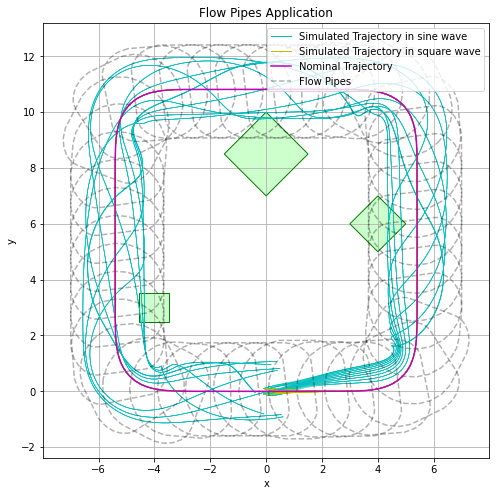

In [23]:
freq = [0.02, .04, .06, .08, .01, .03, .05, .07, .09]
res = []
e = []
V = []
t = 40
n = 40 # number of interval hulls
# disturbances
w1 = 1
w2 = 1  
sol_l = find_se2_invariant_set(svd(3*pi/4))
ref = SE_Dist.simulate(t, 0, w1, w2, 0, 0, 0, dist='sine', sol= sol_l, use_approx=False)


for theta0 in np.linspace(-pi/10, pi/10, 2):
    for x0 in np.linspace(-.1, .1, 2):
        for y0 in np.linspace(-.1, .1, 2):
                init_e = array([[x0, y0, theta0]]).T
                V0 = init_e.T@sol['P']@init_e
                V.append(V0)
                e.append(init_e)
                for i in freq:
                    r = SE_Dist.simulate(40, i, w1, w2, x0, y0, theta0, dist='sine', sol= sol_l, use_approx=False)
                    r2 = SE_Dist.simulate(40, i, w1, w2, x0, y0, theta0, dist='maxdV', sol= sol_l, use_approx=False)
                    res.append(r)
                    if theta0 == np.pi/10 and x0 == .1 and y0 == .1 and i == freq[-1]:
                        SE_Dist.plot_simulated(r, name='sine wave', legend=True, save=False, linewidth = 1, color = 'c')
                        SE_Dist.plot_simulated(r2, name='square wave', legend=True, save=False, linewidth = 1, color = 'y')
                    else:
                        SE_Dist.plot_simulated(r, name='', legend=False, save=False, linewidth = .5, color = 'c', alpha = 0.5)
                        SE_Dist.plot_simulated(r2, name='', legend=False, save=False, linewidth = .5, color = 'y', alpha = 0.5)
                
i = np.array(V).argmax()
print(e[i])
e0 = se2_log(array(e[i]).reshape(3,))
print(e0)

flow_pipes_LMI, intervalhull_LMI, nom = flowpipes(ref, t, n, e0, w1, w2, sol)
for facet in range(n):
    hs_ch_LMI = plt.plot(flow_pipes_LMI[facet][:,0], flow_pipes_LMI[facet][:,1], color='k', linestyle='--', alpha = 0.3)

P4.plot(facecolor=(0.8,1,0.8), edgecolor='g', linewidth=1)
P3.plot(facecolor=(0.8,1,0.8), edgecolor='g', linewidth=1)
P5.plot(facecolor=(0.8,1,0.8), edgecolor='g', linewidth=1)


h_nom = plt.plot(nom[:,0], nom[:,1], color='m', linestyle='-')

plt.axis('equal')
title('Flow Pipes Application')
xlabel('x')
ylabel('y')

lgd = plt.legend(loc=1)
ax = lgd.axes
handles, labels = ax.get_legend_handles_labels()
handles.append(h_nom[0])
labels.append('Nominal Trajectory')
handles.append(hs_ch_LMI[0])
labels.append('Flow Pipes')
lgd._legend_box = None
lgd._init_legend_box(handles, labels)
lgd._set_loc(lgd._loc)
lgd.set_title(lgd.get_title().get_text())

In [ ]:
sol['alpha']

In [ ]:
B = eye(3)
C = eye(3)
D = zeros((3,3))
sys = control.ss(Ap,B,C,D)
mag, phase, omega = control.freqresp(sys, logspace(-2,2,100))
#i_h_inf_norm = mag.argmax()
#omega_h_inf_norm = omega[i_h_inf_norm]
h_inf_norm = mag.max()
h_inf_norm

In [ ]:
e0

In [ ]:
from math import pi, cos, sin, sqrt
from pyobb.obb import OBB

# creates a lat/lon sphere with a given radius and centered at a given point
def sphere(radius, center, num_slices=30):
    theta_step = 2.0 * pi / (num_slices - 1)
    phi_step = pi / (num_slices - 1.0)
    theta = 0.0
    vertices = []
    for i in range(0, num_slices):
        cos_theta = cos(theta)
        sin_theta = sin(theta)
        phi = 0.0
        for j in range(0, num_slices):
            x = -sin(phi) * cos_theta
            y = -cos(phi)
            z = -sin(phi) * sin_theta
            n = sqrt(x * x + y * y + z * z)
            if n < 0.99 or n > 1.01:
                x /= n
                y /= n
                z /= n
            vertices.append((x * radius + center[0],
                             y * radius + center[1],
                             z * radius + center[2]))
            phi += phi_step
        theta += theta_step
    return vertices

obb = OBB.build_from_points(sphere(1, (0, 0, 0)))

In [14]:
def flowpipes3d(res, points, tf, n):
    t_vect = np.arange(0, tf, 0.05)
    
    y_vect = res['y']
    x, y, theta, x_r, y_r, theta_r, log_e_x, log_e_y, log_e_theta = [y_vect[i, :] for i in range(len(y_vect))]
    
    y = array([x_r,y_r]).T
    
    nom = np.append(y,zeros((y.shape[0],1)), axis = 1) # n*3 (x-y direction) ###########
    
    # bound 
    #theta_circ = np.linspace(0, 2*np.pi, 30)
    #circ = array([1.5*np.cos(theta_circ), 1.5*np.sin(theta_circ), ones(30)]).T # circle in 3D
    
    flowpipes = []
    intervalhull = []
    steps = int(len(t_vect)/n)
    
    for i in range(n):
        # get traj for certain fixed time interval
        nom_i = nom[steps*i:steps*(i+1),:] # steps*3
        
        # interval hull
        obb = OBB.build_from_points(nom_i)
        
        # minkowski sum
        P1 = Polytope(obb.points) # interval hull
        P2 = Polytope(points.T) # invariant set
        P = P1+P2 # sum
        
        p1_vertices = P1.V
        p_vertices = P.V
        flowpipes.append(p_vertices)
        intervalhull.append(p1_vertices)
        
    return flowpipes, intervalhull, nom

In [15]:
n2 = 40
flow_pipes3d_s, intervalhull_s, nom = flowpipes3d(ref,exp_points,t, n2)

Text(0.5, 0, 'y')

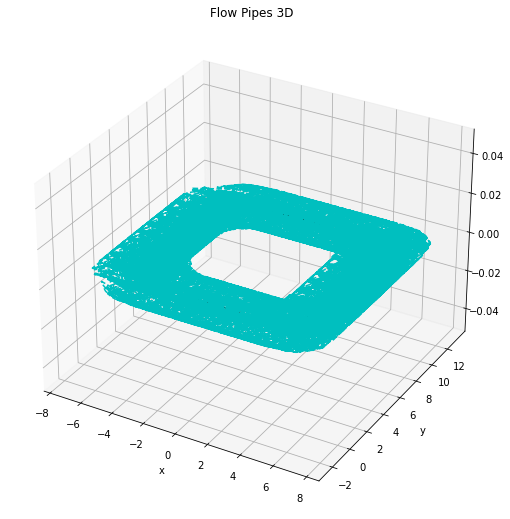

In [16]:
plt.figure(figsize=(9,9))
ax = plt.axes(projection='3d')
h_nom = ax.plot3D(nom[:,0], nom[:,1], color='k', linestyle='-')
for facet in range(n2):
    hs_ch_s = ax.plot3D(flow_pipes3d_s[facet][:,0], flow_pipes3d_s[facet][:,1], color='c', linestyle='--')

title('Flow Pipes 3D')
xlabel('x')
ylabel('y')